In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from comet_ml import Experiment
from ipywidgets import interact, IntSlider

from src.data.dataset import split_dataset, tidy_plays_df
from src.data.data_query import StorageEngine
from src.data.plays_model import game_json_to_plays_list
from src.features.features import basic_features, advanced_features, normalize_plays_coords
#from src.models.xgboost import train_xgb

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import random
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn import metrics

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [23]:
import plotly.express as px
import plotly.graph_objects as go

In [24]:
from requests import request
import json
from pandas.io.json import json_normalize
from matplotlib.gridspec import GridSpec
import pickle
import plotly.graph_objects as go
from comet_ml import Experiment



In [25]:
df = pd.read_csv("./data/processed/plays_2015-2020.csv", index_col=False)
df, test_df = split_dataset(df)
advanced_df = advanced_features(df)
advanced_df.head()

,seconds_elapsed,period_idx,x_coord,y_coord,x_coord_norm,y_coord_norm,dist_from_net,angle_from_net,Backhand,Deflected,...,SHOT,STOP,TAKEAWAY,previous_x_coord,previous_y_coord,seconds_from_previous,dist_from_previous,rebound,angle_change,speed
5394,51.0,1,-55.0,6.0,55.0,-6.0,34.525353,-10.007980,0,0,...,0,0,0,94.0,-34.0,11.0,154.275727,0,0.000000,14.025066
5395,65.0,1,-79.0,0.0,79.0,-0.0,10.000000,0.000000,0,0,...,0,0,0,-37.0,-28.0,7.0,50.477718,0,0.000000,7.211103
5396,66.0,1,-75.0,-1.0,75.0,1.0,14.035669,4.085617,0,0,...,1,0,0,-79.0,0.0,1.0,4.123106,1,4.085617,4.123106
5397,113.0,1,-55.0,-36.0,55.0,36.0,49.517674,46.636577,0,0,...,0,0,0,-91.0,35.0,18.0,79.605276,0,0.000000,4.422515
5398,157.0,1,-61.0,-1.0,61.0,1.0,28.017851,2.045408,0,0,...,0,0,0,-69.0,-22.0,5.0,22.472205,0,0.000000,4.494441


#### Spliting data into train and validation data

In [26]:
df['is_goal'] = np.where(df.event_type_id == "GOAL",1,0)
result_df = pd.concat([advanced_df, df[['is_goal']]], axis=1).round(2).fillna(0)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(result_df.drop(['is_goal','empty_net'],axis=1).fillna(0), result_df['is_goal'], test_size=0.30, random_state=42)


In [18]:
experiment = Experiment(
    project_name="hockey-all-star-analytics",
    workspace="zilto",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/zilto/hockey-all-star-analytics/f1c1d09cc97e4160877727c8bd376ce3



In [28]:
def goal_Rate(pred, y_test): 
    valid = pd.DataFrame()
    valid['pred_prob'] = pred#clf.predict_proba(X_test)[::,1]
    valid['true_labels'] = np.array(y_test)
    percentile = [[np.percentile(valid['pred_prob'], i), np.percentile(valid['pred_prob'], i+5)] for i in range(0,100,5)]

    goal_rate = []
    cum=0
    for i in range(0, len(percentile)):
        goals = valid[ (valid['pred_prob']<=percentile[i][1])&(valid['pred_prob']>percentile[i][0]) & (valid['true_labels']==1)].shape[0]

        no_goals = valid[(valid['pred_prob']<=percentile[i][1])&(valid['pred_prob']>percentile[i][0]) & (valid['true_labels']==0)].shape[0]

        if goals==0:
            goal_rate.append(0)
        else:
            goal_rate.append((goals*100)/(goals+no_goals))
    total_goal = valid[valid['true_labels']==1].shape[0]
    cumulative = []
    for i in range(0, len(percentile)-1):
        goals = valid[(valid['pred_prob']>=percentile[i][0]) & (valid['true_labels']==1)].shape[0]
        cumulative.append(goals*100/total_goal)
    cumulative.append(0)
        
    Shot_prob_percentile = [i for i in range(0,100, 5)]
    return goal_rate, cumulative, Shot_prob_percentile 

In [29]:
##Logistic with distance
clf_dist = LogisticRegression(random_state=0).fit(X_train[['dist_from_net']], y_train)
y_pred_dist = clf_dist.predict_proba(X_test[['dist_from_net']])[::,1]
Goal_rate_dist, cumulative_dist, Shot_percentile =  goal_Rate(y_pred_dist, y_test)

##Logistic with angle
clf_angle = LogisticRegression(random_state=0).fit(X_train[['angle_from_net']], y_train)
y_pred_angle = clf_angle.predict_proba(X_test[['angle_from_net']])[::,1]
Goal_rate_angle,cumulative_angle, Shot_percentile =  goal_Rate(y_pred_angle, y_test)

##Logistic with distance and angle
clf_angle_dist = LogisticRegression(random_state=0).fit(X_train[['dist_from_net','angle_from_net']], y_train)
y_pred_angle_dist = clf_angle_dist.predict_proba(X_test[['dist_from_net','angle_from_net']])[::,1]
Goal_rate_angle_dist,cumulative_angle_dist, Shot_percentile =  goal_Rate(y_pred_angle_dist, y_test)

##Random baseline
random_baseline = [random.uniform(0, 1) for r in  y_test]
Goal_rate_random,cumulative_random, Shot_percentile =  goal_Rate(random_baseline, y_test)

In [ ]:
path = '/Users/henaghonia/Desktop/udem/Sem-1/Data-science/Hockey-all-star-analytics/models/'
filename = path+'logistic_dist.sav'
pickle.dump(clf_dist, open(filename, 'wb'))
filename = path+'logistic_angle.sav'
pickle.dump(clf_angle, open(filename, 'wb'))
filename = path+'logistic_angle_dist.sav'
pickle.dump(clf_angle_dist, open(filename, 'wb'))

In [ ]:
%% writefile src/models/logistic_comet.py
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    project_name="hockey-all-star-analytics",
    workspace="zilto",
)
path = "/Users/henaghonia/Desktop/udem/Sem-1/Data-science/Hockey-all-star-analytics/models/"

experiment.log_model("Logistic regression with distance feature only", path+"logistic_dist.sav")
experiment.log_model("Logistic regression with angle feature only", path+"logistic_angle.sav")
experiment.log_model("Logistic regression with distance and angle feature ", path+"logistic_angle_dist.sav")
experiment.end()

#### For test data

In [36]:
def feature_data(test_df):
    test_advanced_df = advanced_features(test_df)
    
    test_df['is_goal'] = np.where(test_df.event_type_id == "GOAL",1,0)
    result_df = pd.concat([test_advanced_df, test_df[['is_goal','game_type']]], axis=1).round(2).fillna(0)
    test_data = result_df.replace({np.nan: 0, np.inf:0, -np.inf:0})
    
    return test_data[(test_data['game_type']=="R")], test_data[(test_data['game_type']=="P")]
Regular_test, play_off_test = feature_data(test_df)

In [27]:
Regular_pred = pd.DataFrame()
Regular_pred['pred_proba_dist_only'] = clf_dist.predict_proba(Regular_test[['dist_from_net']])[::,1]
Regular_pred['pred_proba_angle_only'] = clf_angle.predict_proba(Regular_test[['angle_from_net']])[::,1]
Regular_pred['pred_proba_dist_angle'] = clf_angle_dist.predict_proba(Regular_test[['dist_from_net','angle_from_net']])[::,1]

Regular_pred['Prediction_dist_only'] = clf_dist.predict(Regular_test[['dist_from_net']])
Regular_pred['Prediction_angle_only'] = clf_angle.predict(Regular_test[['angle_from_net']])
Regular_pred['Prediction_dist_angle'] = clf_angle_dist.predict(Regular_test[['dist_from_net','angle_from_net']])

Regular_pred['actual'] = np.array(Regular_test['is_goal'])

In [38]:
play_off_pred = pd.DataFrame()
play_off_pred['pred_proba_dist_only'] = clf_dist.predict_proba(play_off_test[['dist_from_net']])[::,1]
play_off_pred['pred_proba_angle_only'] = clf_angle.predict_proba(play_off_test[['angle_from_net']])[::,1]
play_off_pred['pred_proba_dist_angle'] = clf_angle_dist.predict_proba(play_off_test[['dist_from_net','angle_from_net']])[::,1]

play_off_pred['Prediction_dist_only'] = clf_dist.predict(play_off_test[['dist_from_net']])
play_off_pred['Prediction_angle_only'] = clf_angle.predict(play_off_test[['angle_from_net']])
play_off_pred['Prediction_dist_angle'] = clf_angle_dist.predict(play_off_test[['dist_from_net','angle_from_net']])

play_off_pred['actual'] = np.array(play_off_test['is_goal'])


In [40]:
play_off_pred.to_csv('data/processed/play_off_prediction_logistic.csv', index=False)
Regular_pred.to_csv('data/processed/Regular_prediction_logistic.csv', index=False)

In [45]:
#%%writefile src/visualization/plots.py
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve, CalibrationDisplay
import pandas as pd
import numpy as np

def plots (clf, X_test, y_test):
    valid = pd.DataFrame()
    valid['pred_prob'] = clf.predict_proba(X_test)[::,1]
    valid['true_labels'] = np.array(y_test)
    percentile = [[np.percentile(valid['pred_prob'], i), np.percentile(valid['pred_prob'], i+5)] for i in range(0,100,5)]

    goal_rate = []
    cum=0
    for i in range(0, len(percentile)):
        goals = valid[ (valid['pred_prob']<=percentile[i][1])&(valid['pred_prob']>percentile[i][0]) & (valid['true_labels']==1)].shape[0]

        no_goals = valid[(valid['pred_prob']<=percentile[i][1])&(valid['pred_prob']>percentile[i][0]) & (valid['true_labels']==0)].shape[0]

        if goals==0:
            goal_rate.append(0)
        else:
            goal_rate.append((goals*100)/(goals+no_goals))
    total_goal = valid[valid['true_labels']==1].shape[0]
    
    cumulative = []
    for i in range(0, len(percentile)):
        goals = valid[(valid['pred_prob']>=percentile[i][0]) & (valid['true_labels']==1)].shape[0]
        cumulative.append(goals*100/total_goal)
    #cumulative.append(0)
        
    Shot_prob_percentile = [i for i in range(0,100, 5)]
    
    sns.set(rc={'figure.figsize':(10,5)})
    #ROC_AUC
    fpr, tpr, _ = metrics.roc_curve(y_test,  valid['pred_prob'])
    auc = metrics.roc_auc_score(y_test, valid['pred_prob'])
    plt.plot(fpr,tpr,label="logistic(1-Goals) , auc="+str(auc))
    fpr, tpr, _ = metrics.roc_curve(y_test,  random_baseline)
    plt.legend(loc=4)
    plt.xticks(rotation=50)
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive rate', fontsize=16)
    #plt.show()
    plt.savefig("/Users/henaghonia/Desktop/udem/Sem-1/Data-science/ift6758-Milestone2_blog/ift6758-Milestone2_blog/images/ROC_AUC1.png")
    plt.show()
    
    ##Plot of goal rate vs Shot probability percentile
    plt.plot(Shot_prob_percentile, goal_rate)
    plt.xlim(max(Shot_prob_percentile), min(Shot_prob_percentile))
    plt.ylim(0, 100)
    plt.xlabel('Shot probability model percentile', fontsize=14)
    plt.ylabel('Goal rate', fontsize=14)
    #plt.show()
    plt.savefig("/Users/henaghonia/Desktop/udem/Sem-1/Data-science/ift6758-Milestone2_blog/ift6758-Milestone2_blog/images/Goal_rate_Shot_prob.png")
    plt.show()
    
    ##Plot of cumulative goal rate vs Shot probability percentile
    plt.plot(Shot_prob_percentile, cumulative)
    plt.xlim(max(Shot_prob_percentile), min(Shot_prob_percentile))
    #plt.ylim(0, 100)
    plt.xlabel('Shot probability model percentile', fontsize=14)
    plt.ylabel('Goal rate', fontsize=14)
    #plt.show()
    plt.savefig("/Users/henaghonia/Desktop/udem/Sem-1/Data-science/ift6758-Milestone2_blog/ift6758-Milestone2_blog/images/cum_Shot_prob.png")
    plt.show()
    
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    colors = plt.cm.get_cmap("Dark2")

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    display = CalibrationDisplay.from_predictions(
            
            valid['true_labels'],
            valid['pred_prob'],
            name='logistic',
            n_bins=40,
            ax=ax_calibration_curve,
            
        )
    

    
    ax_calibration_curve.grid()
    ax_calibration_curve.set_title("Calibration plots")
    plt.savefig("/Users/henaghonia/Desktop/udem/Sem-1/Data-science/ift6758-Milestone2_blog/ift6758-Milestone2_blog/images/Calibration_logistic.png")


    
plots (clf_dist, X_test[['dist_from_net']], y_test)



Writing src/visualization/plots.py


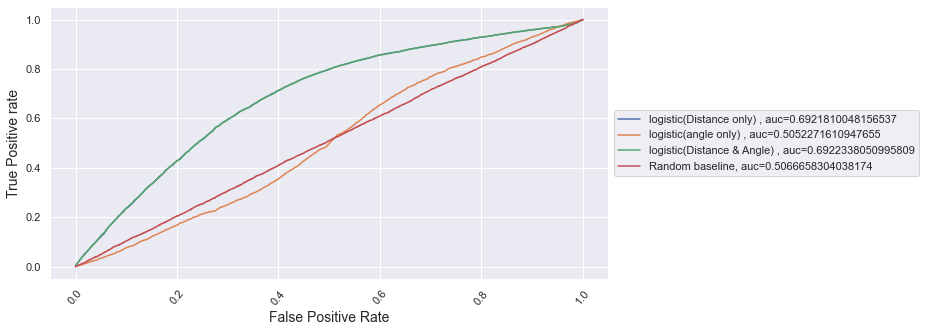

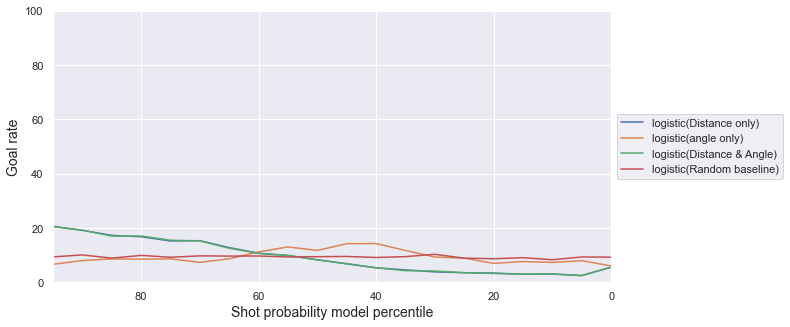

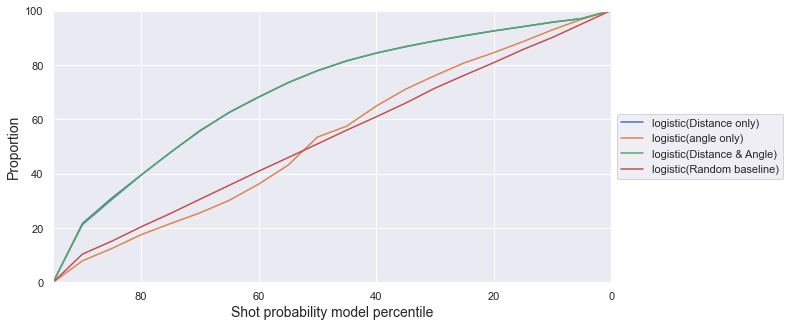

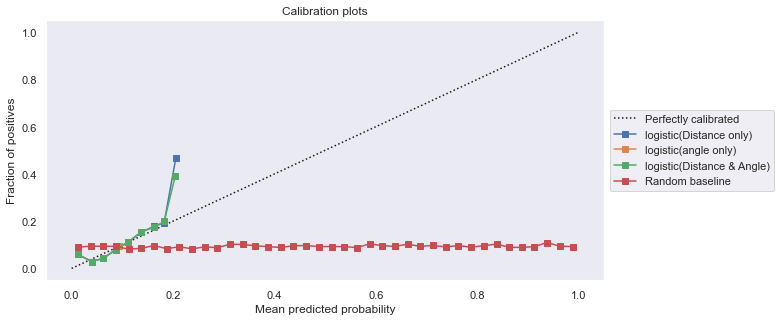

In [32]:
def plots_evaluation(Goal_rate_dist, cumulative_dist, Goal_rate_angle,cumulative_angle,Goal_rate_angle_dist,cumulative_angle_dist,Goal_rate_random,cumulative_random,y_test,y_pred_dist,y_pred_angle,y_pred_angle_dist,random_baseline,Shot_percentile):
    sns.set(rc={'figure.figsize':(10,5)})
    fpr_dist, tpr_dist, _ = metrics.roc_curve(y_test, y_pred_dist)
    auc_dist = metrics.roc_auc_score(y_test, y_pred_dist)
    plt.plot(fpr_dist,tpr_dist,label="logistic(Distance only) , auc="+str(auc_dist))
    experiment.log_metric("logistic(Distance only) ", auc_dist)
    
    fpr_angle, tpr_angle, _ = metrics.roc_curve(y_test, y_pred_angle)
    auc_angle = metrics.roc_auc_score(y_test, y_pred_angle)
    plt.plot(fpr_angle,tpr_angle,label="logistic(angle only) , auc="+str(auc_angle))
    experiment.log_metric("logistic(angle only)", auc_angle)
    
    fpr_dist_angle, tpr_dist_angle, _ = metrics.roc_curve(y_test, y_pred_angle_dist)
    auc_dist_angle = metrics.roc_auc_score(y_test, y_pred_angle_dist)
    plt.plot(fpr_dist_angle,tpr_dist_angle,label="logistic(Distance & Angle) , auc="+str(auc_dist_angle))
    experiment.log_metric("logistic(Distance & Angle)", auc_dist_angle)
    
    fpr_random, tpr_random, _ = metrics.roc_curve(y_test, random_baseline)
    auc_random = metrics.roc_auc_score(y_test, random_baseline)
    plt.plot(fpr_random,tpr_random,label="Random baseline, auc="+str(auc_random))
    experiment.log_metric("Random baseline", auc_random)
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation=50)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive rate', fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig("/Users/henaghonia/Desktop/udem/Sem-1/Data-science/ift6758-Milestone2_blog/ift6758-Milestone2_blog/images/ROC_AUC_comparison.png",bbox_inches="tight")
    experiment.log_figure(figure_name="AUC_ROC ", overwrite=True, step=None)
    plt.show()
    
    plt.plot(Shot_percentile,Goal_rate_dist , label="logistic(Distance only)")
    plt.plot(Shot_percentile,Goal_rate_angle, label="logistic(angle only)")
    plt.plot(Shot_percentile,Goal_rate_angle_dist, label="logistic(Distance & Angle)")
    plt.plot(Shot_percentile,Goal_rate_random, label="logistic(Random baseline)")
    plt.xlim(max(Shot_percentile), min(Shot_percentile))
    plt.ylim(0, 100)
    plt.xlabel('Shot probability model percentile', fontsize=14)
    plt.ylabel('Goal rate', fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig("/Users/henaghonia/Desktop/udem/Sem-1/Data-science/ift6758-Milestone2_blog/ift6758-Milestone2_blog/images/Goal_rate_comparison.png",bbox_inches="tight")
    experiment.log_figure(figure_name = "Goal rate vs Shot probability model percentile", overwrite=True, step=None) 

    plt.show()
    
    plt.plot(Shot_percentile, cumulative_dist, label="logistic(Distance only)")
    plt.plot(Shot_percentile, cumulative_angle, label="logistic(angle only)")
    plt.plot(Shot_percentile, cumulative_angle_dist, label="logistic(Distance & Angle)")
    plt.plot(Shot_percentile, cumulative_random, label="logistic(Random baseline)")
    plt.xlim(max(Shot_percentile), min(Shot_percentile))
    plt.ylim(0, 100)
    plt.xlabel('Shot probability model percentile', fontsize=14)
    plt.ylabel('Proportion', fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig("/Users/henaghonia/Desktop/udem/Sem-1/Data-science/ift6758-Milestone2_blog/ift6758-Milestone2_blog/images/cum_Shot_prob_comparison.png",bbox_inches="tight")
    experiment.log_figure(figure_name = "Proportion vs Shot probability model percentile", overwrite=True, step=None) 

    plt.show()
    
    #clf_list = [(clf_dist,'logistic(Distance only)'), (clf_angle,'logistic(angle only)'), (clf_angle_dist,'logistic(Distance & Angle)'), ("","Random baseline")]
    lt = [['dist_from_net'], ['angle_from_net'], ['dist_from_net','angle_from_net']]
    clf_list = [(y_pred_dist,'logistic(Distance only)'),(y_pred_angle,'logistic(angle only)'),(y_pred_angle_dist,'logistic(Distance & Angle)'),(random_baseline,"Random baseline")]

    
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    colors = plt.cm.get_cmap("Dark2")

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    calibration_displays = {}
    for i, (clf, name) in enumerate(clf_list):
        display = CalibrationDisplay.from_predictions(
            
            y_test,
            clf,
            name=name,
            n_bins=40,
            ax=ax_calibration_curve,
            
        )
        calibration_displays[name] = display

    
    ax_calibration_curve.grid()
    ax_calibration_curve.set_title("Calibration plots")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig("/Users/henaghonia/Desktop/udem/Sem-1/Data-science/ift6758-Milestone2_blog/ift6758-Milestone2_blog/images/Calibration_comparison.png",bbox_inches="tight")
    experiment.log_figure(figure_name = "Calibration plot", overwrite=True, step=None) 

plots_evaluation(Goal_rate_dist, cumulative_dist, Goal_rate_angle,cumulative_angle,Goal_rate_angle_dist,cumulative_angle_dist,Goal_rate_random,cumulative_random,y_test,y_pred_dist,y_pred_angle,y_pred_angle_dist,random_baseline,Shot_percentile)


In [33]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/zilto/hockey-all-star-analytics/f1c1d09cc97e4160877727c8bd376ce3
COMET INFO:   Metrics:
COMET INFO:     Random baseline            : 0.5066658304038174
COMET INFO:     logistic(Distance & Angle) : 0.6922338050995809
COMET INFO:     logistic(Distance only)    : 0.6921810048156537
COMET INFO:     logistic(angle only)       : 0.5052271610947655
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 12
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (548.47 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: -----

## Question 2

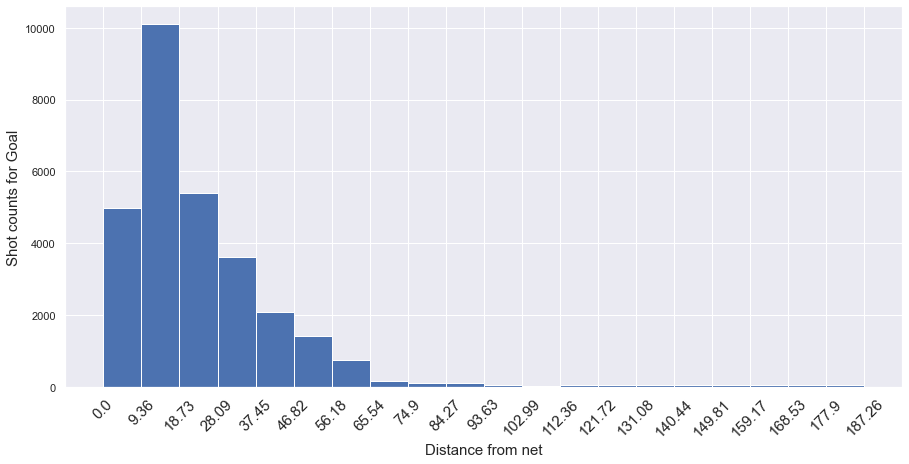

In [91]:
fig, ax = plt.subplots(figsize=(15, 7))
h_vals, h_bins, h_bars = ax.hist(result_df[result_df['is_goal']==1]["dist_from_net"], bins=20, edgecolor="white")
ax.set_xticks(h_bins)
ax.set_xticklabels([round(curr_bin, 2) for curr_bin in h_bins],fontsize=15, rotation=45)
plt.xlabel('Distance from net', fontsize=15)
plt.ylabel('Shot counts for Goal', fontsize=15)

plt.savefig("/Users/henaghonia/Desktop/udem/Sem-1/Data-science/ift6758-Milestone2_blog/ift6758-Milestone2_blog/images/plot_goal1-1.png",bbox_inches="tight")
plt.show()


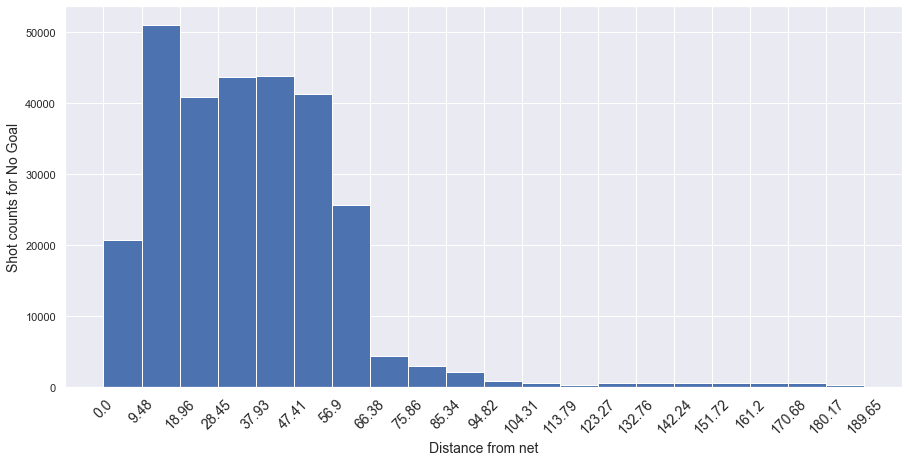

In [88]:
fig, ax = plt.subplots(figsize=(15, 7))
h_vals, h_bins, h_bars = ax.hist(result_df[result_df['is_goal']==0]["dist_from_net"], bins=20, edgecolor="white")
ax.set_xticks(h_bins)
ax.set_xticklabels([round(curr_bin, 2) for curr_bin in h_bins],fontsize=14, rotation=45)
plt.xlabel('Distance from net', fontsize=14)
plt.ylabel('Shot counts for No Goal', fontsize=14)

plt.savefig("/Users/henaghonia/Desktop/udem/Sem-1/Data-science/ift6758-Milestone2_blog/ift6758-Milestone2_blog/images/plot_NOGOAL_1-1.png",bbox_inches="tight")
plt.show()


Binned by angle

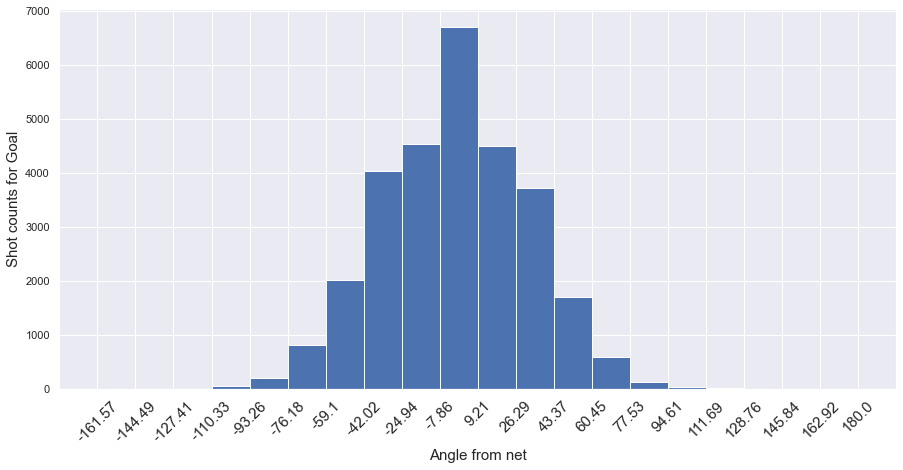

In [89]:
fig, ax = plt.subplots(figsize=(15, 7))
h_vals, h_bins, h_bars = ax.hist(result_df[result_df['is_goal']==1]["angle_from_net"], bins=20, edgecolor="white")
ax.set_xticks(h_bins)
ax.set_xticklabels([round(curr_bin, 2) for curr_bin in h_bins],fontsize=15, rotation=45)
plt.xlabel('Angle from net', fontsize=15)
plt.ylabel('Shot counts for Goal', fontsize=15)

plt.savefig("/Users/henaghonia/Desktop/udem/Sem-1/Data-science/ift6758-Milestone2_blog/ift6758-Milestone2_blog/images/plot_goal1-2.png",bbox_inches="tight")
plt.show()

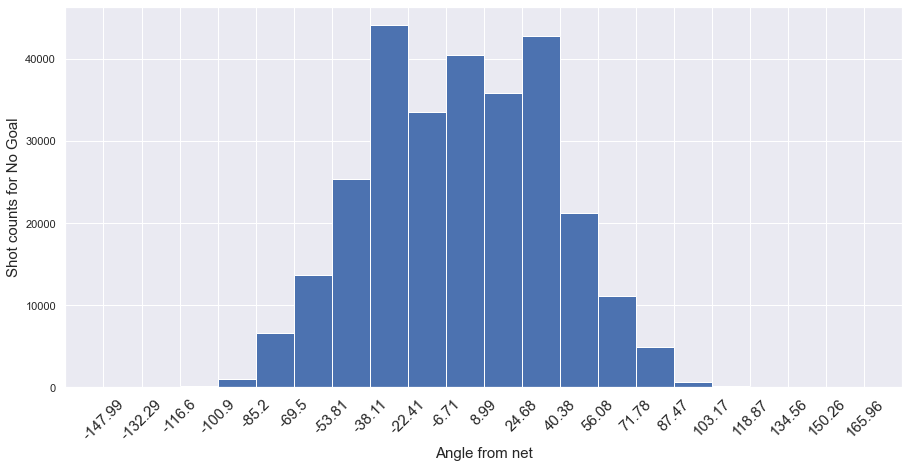

In [90]:
fig, ax = plt.subplots(figsize=(15, 7))
h_vals, h_bins, h_bars = ax.hist(result_df[result_df['is_goal']==0]["angle_from_net"], bins=20, edgecolor="white")
ax.set_xticks(h_bins)
ax.set_xticklabels([round(curr_bin, 2) for curr_bin in h_bins],fontsize=15, rotation=45)
plt.xlabel('Angle from net', fontsize=15)
plt.ylabel('Shot counts for No Goal', fontsize=15)
plt.savefig("/Users/henaghonia/Desktop/udem/Sem-1/Data-science/ift6758-Milestone2_blog/ift6758-Milestone2_blog/images/plot_Nogoal1-2.png",bbox_inches="tight")
plt.show()


In [ ]:
sns.jointplot(data=result_df, x="dist_from_net", y="angle_from_net")
plt.xlabel('Distance from net', fontsize=15)
plt.ylabel('Angle from net', fontsize=15)
plt.savefig("/Users/henaghonia/Desktop/udem/Sem-1/Data-science/ift6758-Milestone2_blog/ift6758-Milestone2_blog/images/jointplot.png",bbox_inches="tight")
plt.show()

In [15]:
sns.set_style('white')
my_color = '#643db8'


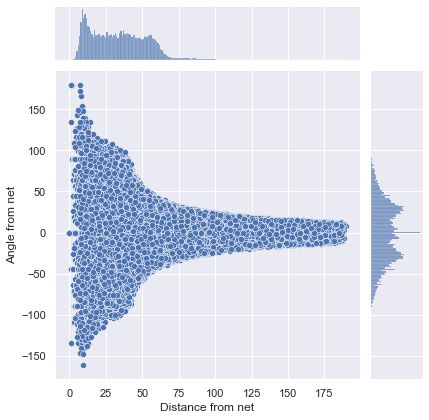

In [16]:
sns.set(rc={'figure.figsize':(20,20)})
ax = sns.jointplot(data=result_df, x="dist_from_net", y="angle_from_net")
ax.ax_joint.set_xlabel('Distance from net')
ax.ax_joint.set_ylabel('Angle from net');
plt.savefig("/Users/henaghonia/Desktop/udem/Sem-1/Data-science/ift6758-Milestone2_blog/ift6758-Milestone2_blog/images/jointplot.png",bbox_inches="tight")
plt.show()

